In [ ]:
#
# The MIT License (MIT)

# Copyright (c) 2021, NVIDIA CORPORATION

# Permission is hereby granted, free of charge, to any person obtaining a copy of
# this software and associated documentation files (the "Software"), to deal in
# the Software without restriction, including without limitation the rights to
# use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of
# the Software, and to permit persons to whom the Software is furnished to do so,
# subject to the following conditions:

# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.

# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS
# FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR
# COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER
# IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN
# CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.
#

## Library packages

In [1]:
import  pandas as pd 
import numpy as np
import xgboost as xgb
import argparse
import os 
import json
import random
import time

from sigir_ecom_challenge_code.evaluation_sigir import cart_abandonment_metric
from sigir_ecom_challenge_code.submission.uploader import upload_submission

import sklearn.metrics as metrics
import matplotlib.pyplot as plt 

import yaml 
import glob
from sklearn.metrics import f1_score


In [2]:
# Function for display dataframe info quickly
def di(df, rows=5):
    display(df.shape)
    display(df.head(rows))

# Function for get evaluation score for different nb_after_add and threshold
def eval_df(df, nb_after_add=0.0, threshold=0.5, full=False):
    if full:
        c_df = df
        preds = (c_df['predictions'].values > threshold).reshape(-1).astype(int).tolist()
        y_valid = c_df['is_purchased-last'].values
        nb_after_add = c_df['nb_after_add'].values
    else:
        c_df = df[df['nb_after_add']==nb_after_add].reset_index(drop=True)
        preds = (c_df['predictions'].values > threshold).reshape(-1).astype(int).tolist()
        y_valid = c_df['is_purchased-last'].values
        nb_after_add = c_df['nb_after_add'].values
    return preds, y_valid, nb_after_add

# Function for get evaluation score for different nb_after_add and threshold
def eval_df_micro(df, nb_after_add=0.0, threshold=0.5):
    c_df = df[df['nb_after_add']==nb_after_add].reset_index(drop=True)
    preds = (c_df['predictions'].values > threshold).reshape(-1).astype(int).tolist()
    y_valid = c_df['is_purchased-last'].values
    nb_after_add = c_df['nb_after_add'].values
    return f1_score(y_valid, preds, average='micro')
    


### Data paths

In [3]:
Data_PATH = '/raid/SIGIR-ecom-data-challenge/data/LB_3.6340/xgboost_data_1'
valid_PATH = 'product_TE_oof/bag_1/'
Data_PATH_0_8 = 'product_TE_oof_0_8/bag_1/'
Data_PATH_10 = 'product_TE_oof_10/bag_1/'
Test_Valid_PATH = '../data/LB_3.6340/fold2/'


### Test and Valid preds loading

In [4]:
# test_preds = pd.read_parquet(Test_Valid_PATH+'test_predictions.parquet')
# valid_preds = pd.read_parquet(Test_Valid_PATH+'valid_predictions.parquet')
valid_files = []
for fold in range(1,6):
    VALID_PARQUET_FILE = os.path.join(valid_PATH, f"fold_{fold}/valid_predictions.parquet")
    valid_files.append(VALID_PARQUET_FILE)
#     VALID_PARQUET_FILE = os.path.join(Data_PATH_10, f"fold_{fold}/valid_predictions.parquet")
#     valid_files.append(VALID_PARQUET_FILE)
print(valid_files)
valid_preds = pd.concat([pd.read_parquet(file) for file in valid_files])
valid_preds = valid_preds.reset_index().drop(columns=['index'])

['product_TE_oof/bag_1/fold_1/valid_predictions.parquet', 'product_TE_oof/bag_1/fold_2/valid_predictions.parquet', 'product_TE_oof/bag_1/fold_3/valid_predictions.parquet', 'product_TE_oof/bag_1/fold_4/valid_predictions.parquet', 'product_TE_oof/bag_1/fold_5/valid_predictions.parquet']


### Loading Training files

In [5]:
files = glob.glob(Data_PATH+'/*')
c_df = []
for f in files:
    if 'train' in f:
        print(f)
        c_df.append(pd.read_parquet(f))

train = pd.concat(c_df).reset_index(drop=True)

/raid/SIGIR-ecom-data-challenge/data/LB_3.6340/xgboost_data_1/train-5.parquet
/raid/SIGIR-ecom-data-challenge/data/LB_3.6340/xgboost_data_1/train-2.parquet
/raid/SIGIR-ecom-data-challenge/data/LB_3.6340/xgboost_data_1/train-4.parquet
/raid/SIGIR-ecom-data-challenge/data/LB_3.6340/xgboost_data_1/train-3.parquet
/raid/SIGIR-ecom-data-challenge/data/LB_3.6340/xgboost_data_1/train-1.parquet


### Loading validation files

In [6]:
files = glob.glob(Data_PATH+'/*')
c_df = []
for f in files:
    if 'valid' in f:
        print(f)
        c_df.append(pd.read_parquet(f))

valid = pd.concat(c_df).reset_index(drop=True)

    

/raid/SIGIR-ecom-data-challenge/data/LB_3.6340/xgboost_data_1/valid-2.parquet
/raid/SIGIR-ecom-data-challenge/data/LB_3.6340/xgboost_data_1/valid-5.parquet
/raid/SIGIR-ecom-data-challenge/data/LB_3.6340/xgboost_data_1/valid-3.parquet
/raid/SIGIR-ecom-data-challenge/data/LB_3.6340/xgboost_data_1/valid-1.parquet
/raid/SIGIR-ecom-data-challenge/data/LB_3.6340/xgboost_data_1/valid-4.parquet


In [7]:
# Brif info for validation data
di(valid)

(40011, 54)

,session_id_hash,product_url_id_list-0,product_url_id_list-1,product_url_id_list-2,product_url_id_list-3,product_url_id_list-4,event_type_list-0,event_type_list-1,event_type_list-2,event_type_list-3,...,mean_sim_desc,std_sim_desc,mean_sim_img,std_sim_img,is_purchased-last,nb_after_add-last,is_test-last,is_valid,fold,original_session_id_hash
0,92040,39038,115045.0,136603.0,1566.0,1566.0,1,1.0,2.0,2.0,...,0.492906,0.342887,0.000000,0.000000,0,0.0,0,1,2,59aed6f87b0c9588173ff79617e6a8ed39edbc5a7f1421...
1,92060,7887,41866.0,86779.0,80881.0,115851.0,2,2.0,2.0,1.0,...,0.013027,0.013027,0.224320,0.224320,0,8.0,0,1,2,59b52db69fab1f25f039551b432ca221d9b3b285e957b2...
2,74210,48385,121132.0,51157.0,7887.0,41996.0,2,2.0,1.0,2.0,...,0.000000,0.000000,0.169598,0.120713,0,2.0,0,1,2,4877ed95bd18d3532087420af5fd1271b76bb2b00cc8aa...
3,50292,160480,41866.0,160480.0,33620.0,170137.0,1,2.0,1.0,2.0,...,0.000000,0.000000,0.000000,0.000000,0,4.0,0,1,2,31055ecf8e25a6a613c50f35f66bd9ef522270b8ec2c2a...
4,80517,113262,7887.0,7887.0,7887.0,80332.0,1,2.0,2.0,2.0,...,0.000000,0.000000,0.000000,0.000000,0,4.0,0,1,2,4e8d7ee4eed23375200decc20394d12fe523b9ef123308...


In [9]:
# Mergng validation data and validation predictions
merged_valid = valid_preds.set_index('session_id_hash').merge(valid.set_index('original_session_id_hash'), left_index=True, right_index=True).reset_index().rename(columns={"index": "session_id_hash"})
di(merged_valid,10)


(40011, 56)

,session_id_hash,nb_after_add,predictions,session_id_hash,product_url_id_list-0,product_url_id_list-1,product_url_id_list-2,product_url_id_list-3,product_url_id_list-4,event_type_list-0,...,nb_queries,mean_sim_desc,std_sim_desc,mean_sim_img,std_sim_img,is_purchased-last,nb_after_add-last,is_test-last,is_valid,fold
0,59b661cac1ca918ce0a7d11bd10bed0cbd51a8e3963cd6...,6.0,0.145712,92062,7887,41866.0,16336.0,7329.0,7329.0,2,...,0.0,0.000000,0.000000,0.000000,0.000000,0,6.0,0,1,1
1,48787bb3c77158f8b0a19045ea2b4b04e809cf7ff8605c...,2.0,0.080086,74213,86279,156464.0,86279.0,41866.0,86279.0,1,...,0.0,0.112991,0.052527,0.000000,0.000000,0,2.0,0,1,1
2,487ac97cb0a4bef1324b0ce0dd5ea395242666e75dd514...,8.0,0.348936,74225,67850,6271.0,23731.0,6271.0,6271.0,2,...,0.0,0.523195,0.301490,0.000000,0.000000,0,8.0,0,1,1
3,512d1a6b2341b936cf61e8e4ae6bb6c47cae796581c6f7...,0.0,0.136211,83235,116102,154246.0,116102.0,54409.0,116102.0,1,...,0.0,0.751726,0.532218,0.478833,0.338601,0,0.0,0,1,1
4,282800f3b2db744de59543412ab466cb9e8ef7619703ab...,0.0,0.265097,41283,41866,7887.0,41866.0,17204.0,17204.0,2,...,0.0,0.000000,0.000000,0.000000,0.000000,0,0.0,0,1,1
5,353c7fbff157f1673dc0f4a95bdea177b400b7e5ad4b1f...,0.0,0.110118,54566,74260,109868.0,101993.0,45237.0,45237.0,1,...,0.0,0.286044,0.249601,0.000000,0.000000,0,0.0,0,1,1
6,3541155b5f3612aece8edd41205a92cca4b01f4790e426...,2.0,0.511274,54586,171019,134418.0,134418.0,41866.0,7887.0,2,...,2.0,0.028322,0.056645,0.269823,0.139024,1,2.0,0,1,1
7,35423295c8f830f49471eb052f8ef5abbe354f7e042b0c...,0.0,0.212982,54591,5671,124668.0,57349.0,51377.0,57349.0,2,...,0.0,0.000000,0.000000,0.000000,0.000000,0,0.0,0,1,1
8,2902efc81cc2415e9489b9ed5f3ec1e8c79e588974eceb...,0.0,0.113071,42134,148370,17329.0,0.0,0.0,0.0,2,...,0.0,0.000000,0.000000,0.000000,0.000000,1,0.0,0,1,1
9,19717cc9468f1f34624a94f4466d3670b58bd3b8c9be99...,0.0,0.059224,26340,29516,47543.0,47543.0,0.0,0.0,1,...,0.0,0.000000,0.000000,0.192806,0.192806,0,0.0,0,1,1


## Checking scores for different threshold and nb_after_add

<b>Validation score for 0.5 and 10 (all 0 )threshold and all nb_after_add</b>

In [12]:
threshold = 0.5
for threshold in np.linspace(0.2,1.0,9):
    preds = (merged_valid['predictions'].values > threshold).reshape(-1).astype(int).tolist()
    labels = merged_valid['is_purchased-last'].values
    nb_after_add = merged_valid['nb_after_add'].values
    print('nb_after_add: All;', 'Threshold:', threshold, 'score:', cart_abandonment_metric(preds, labels, nb_after_add))

nb_after_add: All; Threshold: 0.2 score: 3.3051204576582784
nb_after_add: All; Threshold: 0.30000000000000004 score: 3.6798131001824625
nb_after_add: All; Threshold: 0.4 score: 3.8007190424912936
nb_after_add: All; Threshold: 0.5 score: 3.8221190587887053
nb_after_add: All; Threshold: 0.6000000000000001 score: 3.7665675143239374
nb_after_add: All; Threshold: 0.7 score: 3.7359263869120714
nb_after_add: All; Threshold: 0.8 score: 3.7274443668844466
nb_after_add: All; Threshold: 0.9000000000000001 score: 3.5732415349586804
nb_after_add: All; Threshold: 1.0 score: 3.5498562951490857


<b>Finding validation score different nb_after_add with same threshold</b>

In [13]:
scores = []
for threshold in np.linspace(0.3,0.7,5):
    print("threshold:", round(threshold,2))
    print('nb_after_add | Score')
    print('------------------------------------------')
    score = []
    for val in np.unique(merged_valid['nb_after_add'].values):
        score.append(eval_df_micro(merged_valid, val, threshold))
        print('%11r  |  %4r    ' %(val, eval_df_micro(merged_valid, val, threshold)))
#         print('%11r  |  %4r    ' %(val, cart_abandonment_metric(*eval_df(merged_valid, val, threshold))))
    print()

    scores.append(score)

threshold: 0.3
nb_after_add | Score
------------------------------------------
        0.0  |  0.8257041420118343    
        2.0  |  0.8168359941944847    
        4.0  |  0.8535031847133757    
        6.0  |  0.8172496984318455    
        8.0  |  0.8223330775134305    
       10.0  |  0.7413587604290822    

threshold: 0.4
nb_after_add | Score
------------------------------------------
        0.0  |  0.8274082840236686    
        2.0  |  0.8364296081277214    
        4.0  |  0.8776160145586898    
        6.0  |  0.8799758745476478    
        8.0  |  0.8733691481197238    
       10.0  |  0.7568533969010727    

threshold: 0.5
nb_after_add | Score
------------------------------------------
        0.0  |  0.8273136094674556    
        2.0  |  0.8492017416545719    
        4.0  |  0.8780709736123748    
        6.0  |  0.8920386007237637    
        8.0  |  0.8733691481197238    
       10.0  |  0.7592371871275327    

threshold: 0.6
nb_after_add | Score
----------------------

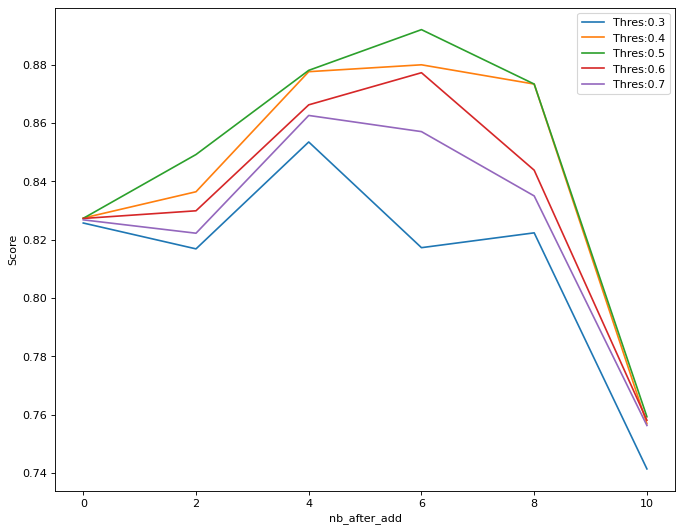

In [14]:
from matplotlib.pyplot import figure
figure(figsize=(10, 8), dpi=80)
x = np.unique(merged_valid['nb_after_add'].values)
thresholds = np.linspace(0.3,0.7,5)
i = 0
for score in scores:
    plt.plot(x, score, label="Thres:"+str(round(thresholds[i],2)))
    i+=1
plt.legend(loc="upper right")
plt.xlabel('nb_after_add')
plt.ylabel('Score') 
plt.show()

<b>Finding validation score different threshold for same nb_after_add</b>

In [15]:
scores = []
thres_values = np.linspace(0.3,0.7,5)
for val in np.unique(merged_valid['nb_after_add'].values):
    print("nb_after_add:", val)
    print('Threshold | Score')
    print('------------------------------------------')
    score = []
    for threshold in thres_values:
        sc = eval_df_micro(merged_valid, val, threshold)
        score.append(sc)
        print('%11r  |  %4r    ' %(round(threshold,2), sc))
    print()
    scores.append(score)

nb_after_add: 0.0
Threshold | Score
------------------------------------------
        0.3  |  0.8257041420118343    
        0.4  |  0.8274082840236686    
        0.5  |  0.8273136094674556    
        0.6  |  0.8272662721893491    
        0.7  |  0.826792899408284    

nb_after_add: 2.0
Threshold | Score
------------------------------------------
        0.3  |  0.8168359941944847    
        0.4  |  0.8364296081277214    
        0.5  |  0.8492017416545719    
        0.6  |  0.8298984034833091    
        0.7  |  0.8222060957910016    

nb_after_add: 4.0
Threshold | Score
------------------------------------------
        0.3  |  0.8535031847133757    
        0.4  |  0.8776160145586898    
        0.5  |  0.8780709736123748    
        0.6  |  0.8662420382165607    
        0.7  |  0.8626023657870793    

nb_after_add: 6.0
Threshold | Score
------------------------------------------
        0.3  |  0.8172496984318455    
        0.4  |  0.8799758745476478    
        0.5  |  0.8

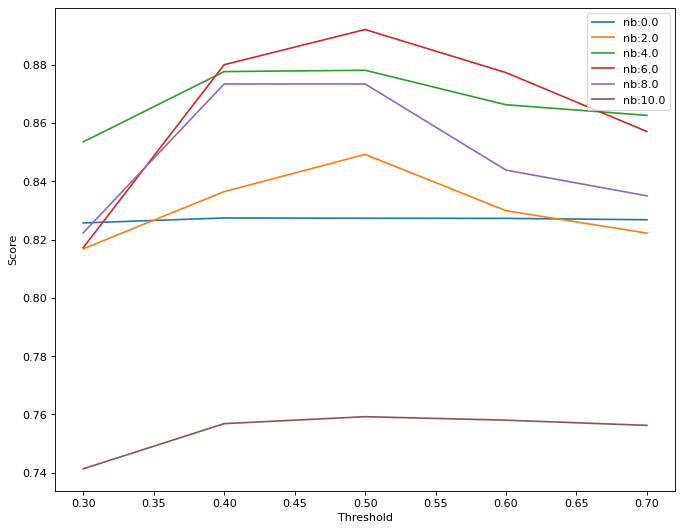

In [16]:
figure(figsize=(10, 8), dpi=80)
x = np.linspace(0.3,0.7,5)
nb_after_add = np.unique(merged_valid['nb_after_add'].values)
i = 0
for score in scores:
    plt.plot(x, score, label="nb:"+str(nb_after_add[i]))
    i+=1
plt.legend(loc="upper right")
plt.xlabel('Threshold')
plt.ylabel('Score') 
plt.show()

In [17]:
print('nb_after_add |    Rows    |    Purchased')
print('------------------------------------------')
for val in np.unique(merged_valid['nb_after_add'].values):
    c_df = merged_valid[merged_valid['nb_after_add']==val].reset_index(drop=True)
    print('%4r         |    %4r    |    %4r' %(val, c_df.shape[0], c_df[c_df['is_purchased-last']==1].shape[0]))
    print()


nb_after_add |    Rows    |    Purchased
------------------------------------------
 0.0         |    21125    |    3701

 2.0         |    6890    |    1740

 4.0         |    4396    |     838

 6.0         |    3316    |     654

 8.0         |    2606    |     577

10.0         |    1678    |     417



In [18]:
print('nb_after_add |    Rows    |    Purchased')
print('------------------------------------------')
for val in np.unique(train['nb_after_add-last'].values):
    c_df = train[train['nb_after_add-last']==val].reset_index(drop=True)
    print('%4r         |    %4r    |    %4r' %(val, c_df.shape[0], c_df[c_df['is_purchased-last']==1].shape[0]))
    print()


nb_after_add |    Rows    |    Purchased
------------------------------------------
 0.0         |    29902    |    2513

 2.0         |    28138    |    7504

 4.0         |    17265    |    3273

 6.0         |    13519    |    2842

 8.0         |    11336    |    2705

10.0         |    74407    |    19268



<b>Comments</b>
<li>From training data it looks like there are way more data points for 10.0 compared to others.</li>
<li>However, in the validation data, the data points were reduced based on evaluation metrics weights.</li>
<li>Considering a large amount of training data for 10.0 it might be possible the nature of validation data might confusing the trained model. Therefore, train a model for 10.0 separately might give a better overall prediction.</li>